In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import doctest
import copy

In [283]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Bicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$. Assume the wheelbase of the vehicle $L$ = 0.9 m

In [284]:
@test 
def bicycle_model(curr_pose, v, delta, dt):
    '''
    >>> bicycle_model((0.0,0.0,0.0), 1.0, 0.0,1)
    (1.0, 0.0, 0.0)
    >>> bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4,1)
    (0.0, 0.0, 0.0) 
    >>> bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4,1)
    (1.0, 0.0, 1.11) 
    '''
    # write code to calculate next_pose
    # refer to the kinematic equations of a bicycle model
    L = 0.9
    x, y, theta = curr_pose
    x += v*np.cos(theta)*dt
    y += v*np.sin(theta)*dt
    theta += (v/L)*np.tan(delta)*dt
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return x, y, theta

Finding tests in bicycle_model
Trying:
    bicycle_model((0.0,0.0,0.0), 1.0, 0.0,1)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4,1)
Expecting:
    (0.0, 0.0, 0.0) 
**********************************************************************
File "__main__", line 6, in bicycle_model
Failed example:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4,1)
Expected:
    (0.0, 0.0, 0.0) 
Got:
    (0.0, 0.0, 0.0)
Trying:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4,1)
Expecting:
    (1.0, 0.0, 1.11) 
**********************************************************************
File "__main__", line 8, in bicycle_model
Failed example:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4,1)
Expected:
    (1.0, 0.0, 1.11) 
Got:
    (1.0, 0.0, 1.111111111111111)


In [285]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and delta values
all_v = np.ones(steps)
all_delta = np.zeros(steps)
for v,delta in zip(all_v,all_delta):
   #instruction to take v, delta and compute new pose    
   straight_trajectory.append(pose)
   # store new pose
   pose = bicycle_model(pose,v,delta,1)
straight_trajectory = np.array(straight_trajectory)

[[0.00000000e+00 0.00000000e+00 1.57079633e+00]
 [6.12323400e-17 1.00000000e+00 1.57079633e+00]
 [1.22464680e-16 2.00000000e+00 1.57079633e+00]
 [1.83697020e-16 3.00000000e+00 1.57079633e+00]
 [2.44929360e-16 4.00000000e+00 1.57079633e+00]
 [3.06161700e-16 5.00000000e+00 1.57079633e+00]
 [3.67394040e-16 6.00000000e+00 1.57079633e+00]
 [4.28626380e-16 7.00000000e+00 1.57079633e+00]
 [4.89858720e-16 8.00000000e+00 1.57079633e+00]
 [5.51091060e-16 9.00000000e+00 1.57079633e+00]]


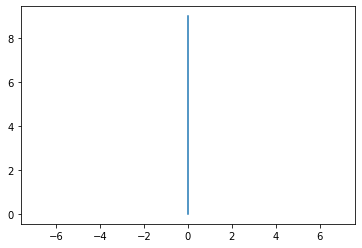

In [286]:
### Plot straight trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,0], straight_trajectory[:,1])
plt.show()

In [297]:
#Circular Trajectory
circular_trajectory = []
pose = (0, 0, np.pi/2)
steps = 100
#fill in v and delta values
all_v = np.ones(steps)
all_delta = np.ones(steps)
for v,delta in zip(all_v,all_delta):
   #instruction to take v, delta and compute new pose    
   circular_trajectory.append(pose)
   # store new pose
   pose = bicycle_model(pose,v,delta,0.35)
circular_trajectory = np.array(circular_trajectory)

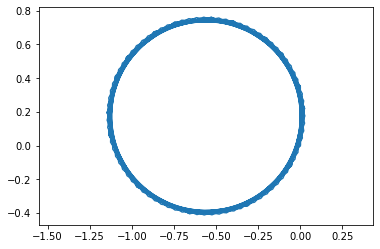

In [298]:
### Plot circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circular_trajectory[:,0], circular_trajectory[:,1])
plt.show()

### Simulate Bicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\delta$. To make it even simpler, $\delta$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\delta = \delta_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\delta_c$?
* When should $\delta$ change from 0 and back?

In [289]:
vc = 1# m/s
delta_c = np.pi/6# rad/s

#calculate time taken to finish a quarter turn (pi/4)
# unlike you would need to take into account v_c and L of the vehicle as well
t_turn = int((np.pi/2)/delta_c)

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10/vc), int(5/vc), int(8/vc)

all_delta = [0]*t_straight1 + [delta_c]*t_turn + \
        [0]*t_straight2 + [delta_c]*t_turn + \
        [0]*t_straight3 + [-delta_c]*t_turn
all_v = vc*np.ones_like(all_delta)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_delta

In [290]:
def get_open_loop_commands(route, vc, deltac):
    all_delta = []
    omegas = {'straight':0, 'left':deltac, 'right':-deltac}
    for direction,value in route:
        total_time = int(value/vc) if direction == 'straight' else int(np.deg2rad(value)/deltac)
        all_delta += [omegas[direction]]*total_time
    all_v = vc*np.ones_like(all_delta)
    return all_v,all_delta

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $delta_c = \pi/12$

In [291]:
all_v, all_delta = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)],1,np.pi/12)
print(all_delta)

[0, 0, 0, 0, 0, -0.2617993877991494, -0.2617993877991494, -0.2617993877991494, -0.2617993877991494, -0.2617993877991494, -0.2617993877991494, 0, 0, 0, 0, 0, 0, 0.2617993877991494, 0.2617993877991494, 0.2617993877991494, 0.2617993877991494, 0.2617993877991494]


In [292]:
robot_trajectory = []
all_v, all_delta = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)],1,np.pi/12)
pose = np.array([0, 0, np.pi/2])
for v, delta in zip(all_v, all_delta):
     robot_trajectory.append(pose)
     pose = bicycle_model(pose,v,delta,1)
   # store new pose
robot_trajectory = np.array(robot_trajectory)

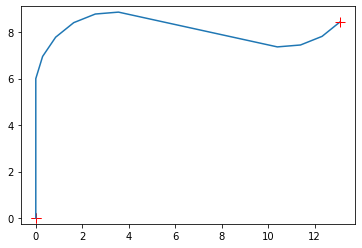

In [293]:
plt.figure()
plt.axes().set_aspect("equal","datalim")
xi,yi, _ = robot_trajectory[0]
xf,yf, _ = robot_trajectory[-1]
plt.plot(0, 0, 'r+', ms=10)
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(robot_trajectory[:,0], robot_trajectory[:,1])
plt.plot(xf, yf, 'r+', ms=10)
plt.show()

### Shape the turn
Let us try something cooler than before (though a bit tricky in open loop). Instead of boring circular arcs, change the steering angle so that the robot orientation changes as shown in the equation below

$\theta = (\theta_i - \theta_f) * (1 - 3x^2 + 2\theta^3) + \theta_f  \thinspace \vee x \in [0,1]$

First let us plot this

In [300]:
def poly_turn(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    return (theta_i-theta_f) * (1 - 3 * x * x + 2 * (x**3)) + theta_f

In [301]:
theta_dot = np.diff(poly_turn(np.pi/2, 0))
print(theta_dot)

[-0.05386819 -0.14436674 -0.20900856 -0.24779366 -0.26072202 -0.24779366
 -0.20900856 -0.14436674 -0.05386819]


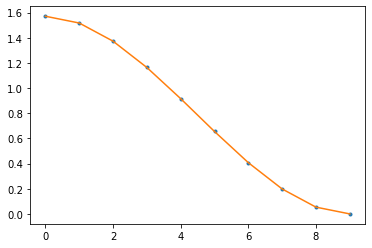

In [302]:
plt.figure()
plt.plot(poly_turn(np.pi/2, 0),'.')
plt.plot(poly_turn(np.pi/2, 0))